In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos import *

In [2]:
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set random seed
np.random.seed(2027)

from collections import OrderedDict

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.set_random_seed(2027)

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 2.7.14+ (default, Apr 19 2019, 15:48:06) [GCC 7.4.1 20190129]
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98-2.5, 1.55-1.98, 1.2-1.55)
zone = 0

# timezone: (0,1,2) -> BX=(-1,0,+1)
timezone = 1

#maxevents = 200000
maxevents = -1

# Input files
signal = 'signal_add.20200721.npz'
signal_displ = 'signal_displ_add.20200721.npz'
bkgnd = 'bkgnd_add.20200716.npz'

# Input data columns
part_metadata = ['part_invpt', 'part_eta', 'part_phi',
                 'part_vx', 'part_vy', 'part_vz',
                 'part_d0', 'part_sector', 'part_zone']
part_metadata = OrderedDict(zip(part_metadata, range(len(part_metadata))))
#print(part_metadata)

hits_metadata = ['emtf_layer', 'ri_layer', 'zones', 'timezones',
                 'emtf_chamber', 'emtf_segment', 'detlayer', 'bx',
                 'emtf_phi', 'emtf_bend', 'emtf_theta', 'emtf_theta_alt',
                 'emtf_qual', 'emtf_time', 'fr', 'rsvd']
hits_metadata = OrderedDict(zip(hits_metadata, range(len(hits_metadata))))
#print(hits_metadata)

# Image format
num_channels = 1
num_cols = 300
num_rows = 8
image_format = (num_rows, num_cols, num_channels)

# Image sliding window
image_stride = (min_emtf_strip, max_emtf_strip, coarse_emtf_strip)

# Parameter
num_params = 5

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents    : {0}'.format(maxevents))
logger.info('.. image_format : {0}'.format(image_format))
logger.info('.. image_stride : {0}'.format(image_stride))
logger.info('.. num_params   : {0}'.format(num_params))

[INFO    ] Processing zone 0 timezone 1
[INFO    ] .. maxevents    : -1
[INFO    ] .. image_format : (8, 300, 1)
[INFO    ] .. image_stride : (320, 5120, 16)
[INFO    ] .. num_params   : 5


In [4]:
# More settings

ind_part_invpt = part_metadata['part_invpt']
ind_part_d0 = part_metadata['part_d0']

ind_ri_layer = hits_metadata['ri_layer']
ind_zones = hits_metadata['zones']
ind_timezones = hits_metadata['timezones']
ind_emtf_phi = hits_metadata['emtf_phi']

zo_layer_lut = np.array([find_emtf_zo_layer(ri_layer, zone) for ri_layer in range(19)], dtype=np.int32)

zo_layer_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1'],
  ['GE1/1', 'ME1/1', 'ME1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2'],
]

anchor_row = find_emtf_zo_layer(3, zone)    # ME2/1
if anchor_row == -99:
  anchor_row = find_emtf_zo_layer(4, zone)  # ME2/2

if zone == 0:
  invpt_bins = np.array([-0.49306814, -0.32798037, -0.18947332, -0.06285281, 0.06285281, 0.18947332, 0.32798037, 0.49306814])
  dzero_bins = np.array([-149.05425911, -81.99509811, -27.70436335, -3.31677109, 3.31677109, 27.70436335, 81.99509811, 149.05425911])
elif zone == 1:
  invpt_bins = np.array([-0.49362888, -0.3378489, -0.2015404, -0.06807981, 0.06807981, 0.2015404, 0.3378489, 0.49362888])
  dzero_bins = np.array([-148.39244453, -75.48090935, -24.77919722, -2.7400052, 2.7400052, 24.77919722, 75.48090935, 148.39244453])
elif zone == 2:
  invpt_bins = np.array([-0.43329155, -0.24434048, -0.14303024, -0.0501708, 0.0501708, 0.14303024, 0.24434048, 0.43329155])
  dzero_bins = np.array([-148.3895298, -73.95162964, -24.58334907, -3.2076813, 3.2076813, 24.58334907, 73.95162964, 148.3895298])
else:
  raise RuntimeError('Could not recognize zone: {0}'.format(zone))

num_invpt_bins = len(invpt_bins)-1
num_d0_bins = len(dzero_bins)-1

In [5]:
# Binning functions

def my_digitize(x, bins):
  # first and last bins include underflow and overflow
  ind = np.searchsorted(bins, x)
  ind = np.clip(ind-1, 0, len(bins)-2)  # starts from 0
  return ind

def digitize_invpt_and_d0(invpt, d0):
  ind0 = my_digitize(invpt, invpt_bins)
  ind1 = my_digitize(d0, dzero_bins)
  return (ind0, ind1)

In [6]:
# Plotting functions

# matplotlib hist2d takes the (x, y) arrays as input, do the binning and plot.
# this hist2d takes a single, already-binned-in-2d, array as input, and plot.
#
# based on root2matplotlib from rootpy:
#     http://www.rootpy.org/_modules/rootpy/plotting/root2matplotlib.html#hist2d
#
def hist2d_on_binned_array(hist, xedges, yedges, ax=None, cmap=None, vmin=None, vmax=None, colorbar=False):
  if ax is None:
    ax = plt.gca()
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = hist.T.ravel()
  h, xedges, yedges, im = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=vmin, vmax=vmax)
  if colorbar:
    cb = ax.figure.colorbar(im, ax=ax)
  return h, xedges, yedges, im

# same thing for 1d
def hist_on_binned_array(hist, edges, ax=None):
  if ax is None:
    ax = plt.gca()
  x = (edges[1:] + edges[:-1])/2
  h, edges, patches = ax.hist(x, weights=hist, bins=edges)
  return h, edges, patches

In [7]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

### Load data

In [8]:
def load_signal(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    logger.info('out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_aux = loaded['out_aux']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    logger.info('out_aux: {0} out_hits: {1}'.format(out_aux.shape, out_hits.shape))
  return (out_aux, out_hits)

In [9]:
part_data, hits_data, simhits_data = load_signal(signal)

#bkg_aux_data, bkg_hits_data = load_bkgnd(bkgnd)

[INFO    ] Loading from signal_add.20200721.npz
[INFO    ] out_part: (2000000, 9) out_hits: (2000000, None, 16) out_simhits: (2000000, None, 16)


In [10]:
# Debug
with np.printoptions(linewidth=100, threshold=1000):
  for i in range(5):
    print('Event {0}'.format(i))
    print(part_data[i])
    print(hits_data[i])
    print(simhits_data[i])

Event 0
[-2.5611117e-01  2.1183386e+00 -6.1635029e-01  6.7432784e-04  9.9125458e-04 -4.6484246e+00
 -1.1986600e-03  5.0000000e+00  0.0000000e+00]
[[   0    0    4    3    2    0    0    0 2548    5   18   17   -6    0    0  -99]
 [   0    0    4    3    2    1    0    0 2548    5   17   18   -6    0    0  -99]
 [   2    3    4    3   19    0    0    0 2684    2   16   16    6    0    1  -99]
 [   3    5    4    3   28    0    0    0 2819   15   17   16   -5    0    0  -99]
 [   3    5    4    3   28    1    0    0 2728    0   16   17   -5    0    0  -99]
 [   4    7    4    3   37    0    0    0 2736    0   16   16   -5    0    0  -99]
 [   9    9    4    2   55    0    0    0 2505    0   18   18    0    0    1  -99]
 [  10   12    4    2   73    0    0    0 2675    0   19   19    0    0    1  -99]
 [   7   14    4    2   82    0    0    0 2888    0   17   17    0    1    0  -99]
 [   7   14    4    2   82    1    0    0 2714    0   17   17    0    1    0  -99]
 [   8   16    4    2   

In [11]:
# Debug
try:
  with np.printoptions(linewidth=100, threshold=1000):
    for i in range(10):
      print('Event {0}'.format(i))
      print(bkg_aux_data[i])
      print(bkg_hits_data[i])
except:
  pass

Event 0


### Zone selection

In [12]:
part_zone = part_data[:, part_metadata['part_zone']].astype(np.int32)

zone_mask = (part_zone == zone)

zerosimhits_mask = (simhits_data.row_lengths == 0)

zone_mask = zone_mask & (~zerosimhits_mask)

In [13]:
zone_part_data = part_data[zone_mask]
zone_hits_data = ragged_row_boolean_mask(hits_data, zone_mask)
zone_simhits_data = ragged_row_boolean_mask(simhits_data, zone_mask)

logger.info('zone_part_data: {0} zone_hits_data: {1} zone_simhits_data: {2}'.format(zone_part_data.shape, zone_hits_data.shape, zone_simhits_data.shape))

[INFO    ] zone_part_data: (786769, 9) zone_hits_data: (786769, None, 16) zone_simhits_data: (786769, None, 16)


In [14]:
# Debug
with np.printoptions(linewidth=100, threshold=1000):
  for i in range(5):
    print('Event {0}'.format(i))
    print(zone_part_data[i])
    print(zone_hits_data[i])
    print(zone_simhits_data[i])

Event 0
[-2.5611117e-01  2.1183386e+00 -6.1635029e-01  6.7432784e-04  9.9125458e-04 -4.6484246e+00
 -1.1986600e-03  5.0000000e+00  0.0000000e+00]
[[   0    0    4    3    2    0    0    0 2548    5   18   17   -6    0    0  -99]
 [   0    0    4    3    2    1    0    0 2548    5   17   18   -6    0    0  -99]
 [   2    3    4    3   19    0    0    0 2684    2   16   16    6    0    1  -99]
 [   3    5    4    3   28    0    0    0 2819   15   17   16   -5    0    0  -99]
 [   3    5    4    3   28    1    0    0 2728    0   16   17   -5    0    0  -99]
 [   4    7    4    3   37    0    0    0 2736    0   16   16   -5    0    0  -99]
 [   9    9    4    2   55    0    0    0 2505    0   18   18    0    0    1  -99]
 [  10   12    4    2   73    0    0    0 2675    0   19   19    0    0    1  -99]
 [   7   14    4    2   82    0    0    0 2888    0   17   17    0    1    0  -99]
 [   7   14    4    2   82    1    0    0 2714    0   17   17    0    1    0  -99]
 [   8   16    4    2   

### Build images

In [15]:
# Build images

from numba import njit

# Set the number of threads
#numba.config.NUMBA_NUM_THREADS = 32

def build_zone_images():
  zone_images = np.zeros((zone_part_data.shape[0],) + image_format, dtype=np.bool)

  # Get hit variables.
  zone_simhits_row_splits = zone_simhits_data.row_splits
  zone_simhits_ri_layer = zone_simhits_data.values[:, ind_ri_layer]
  zone_simhits_zones = zone_simhits_data.values[:, ind_zones]
  zone_simhits_timezones = zone_simhits_data.values[:, ind_timezones]
  zone_simhits_emtf_phi = zone_simhits_data.values[:, ind_emtf_phi]

  build_zone_images_jit_0(zone_part_data,
                          zone_simhits_row_splits,
                          zone_simhits_ri_layer,
                          zone_simhits_zones,
                          zone_simhits_timezones,
                          zone_simhits_emtf_phi,
                          zone_images)
  return zone_images

@njit
def build_zone_images_jit_0(zone_part_data,
                            zone_simhits_row_splits,
                            zone_simhits_ri_layer,
                            zone_simhits_zones,
                            zone_simhits_timezones,
                            zone_simhits_emtf_phi,
                            zone_images):
  # Loop over events. Get hit variables per event.
  for i in range(zone_part_data.shape[0]):
    _slice = slice(zone_simhits_row_splits[i], zone_simhits_row_splits[i+1])
    build_zone_images_jit_1(zone_simhits_ri_layer[_slice],
                            zone_simhits_zones[_slice],
                            zone_simhits_timezones[_slice],
                            zone_simhits_emtf_phi[_slice],
                            zone_images[i])

@njit
def build_zone_images_jit_1(x_ri_layer,
                            x_zones,
                            x_timezones,
                            x_emtf_phi,
                            img):
  # Set selection, row, col.
  _sel_fn = lambda zones_word, timezones_word: bool(zones_word & (1<<(2-zone))) and bool(timezones_word & (1<<(2-timezone)))
  _row_fn = lambda ri_layer: zo_layer_lut[ri_layer]
  _col_fn = lambda emtf_phi: (emtf_phi - min_emtf_strip) // coarse_emtf_strip

  # Loop over hits. If hit is selected, set (row, col) to True.
  for i in range(x_ri_layer.shape[0]):
    sel = _sel_fn(x_zones[i], x_timezones[i])
    row = _row_fn(x_ri_layer[i])
    col = _col_fn(x_emtf_phi[i])
    if sel and (row >= 0) and (col >= 0):
      img[row, col] = 1


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numba/0.43.1-pafccj/lib/python2.7/site-packages/numba/__init__.py:78: UserWarning: llvmlite version format not recognized!
  warnings.warn("llvmlite version format not recognized!")


In [16]:
# Display images

def display_image(img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zo_layer_labels[zone])))
  ax.set_yticklabels(zo_layer_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

In [17]:
%%time

zone_images = build_zone_images()

logger.info('zone_images: {0}'.format(zone_images.shape))

[INFO    ] zone_images: (786769, 8, 300, 1)


CPU times: user 791 ms, sys: 872 ms, total: 1.66 s
Wall time: 1.67 s


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Event 0
pt: 3.90455434323


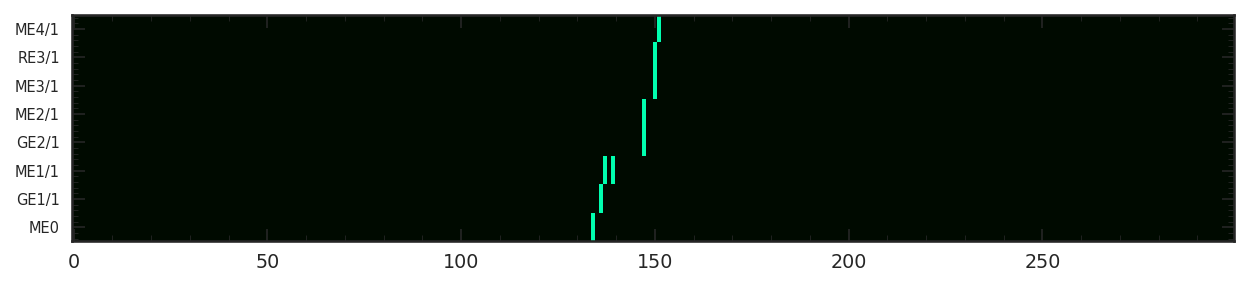

Event 1
pt: 2.49711024644


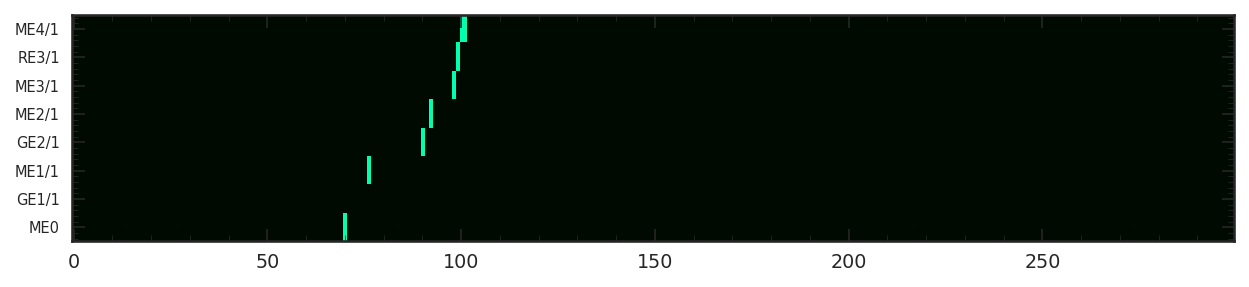

Event 2
pt: 5.66378507264


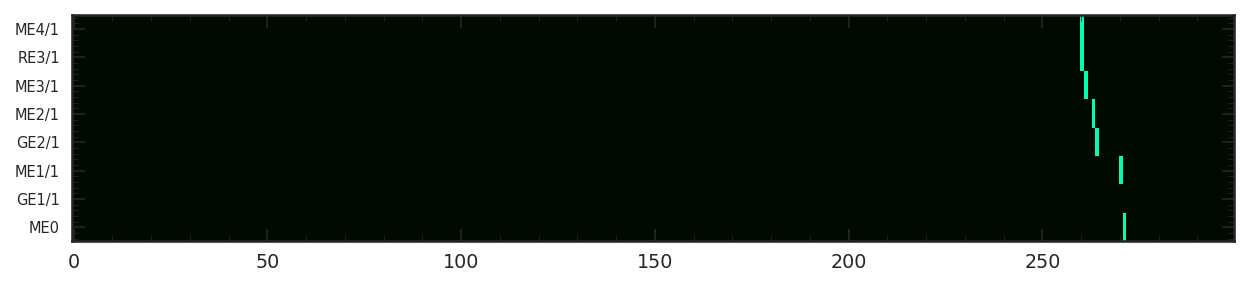

Event 3
pt: 2.88331654986


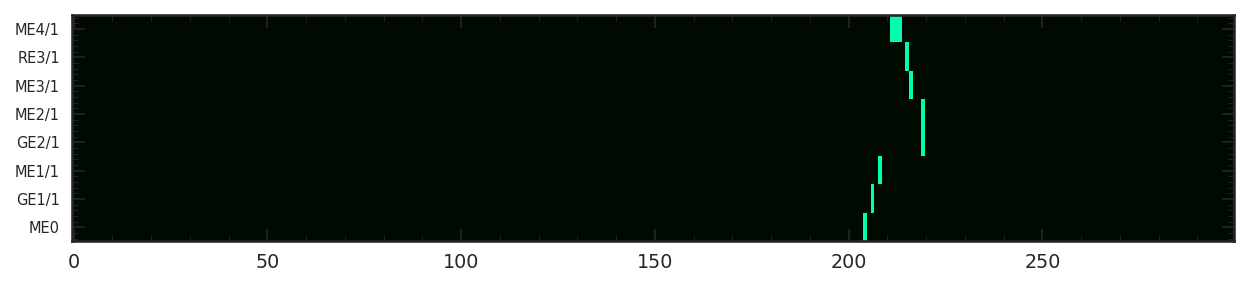

Event 4
pt: 3.21029884748


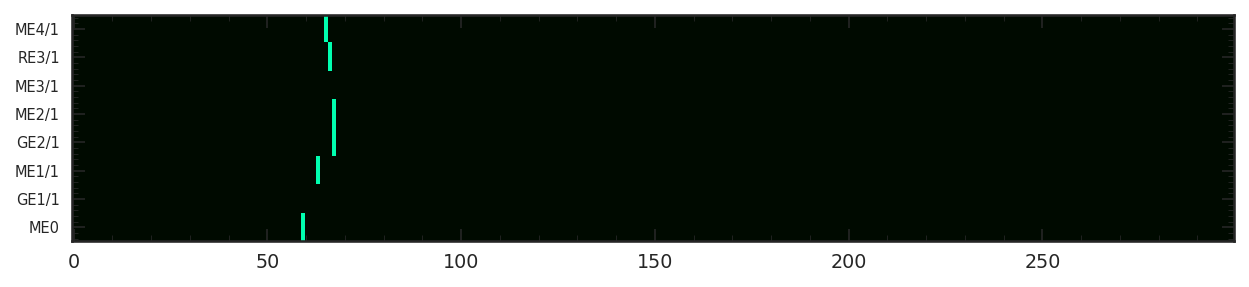

In [18]:
# Debug
for i in range(5):
  print('Event {0}'.format(i))
  print('pt: {0}'.format(1.0/np.abs(zone_part_data[i, 0])))
  display_image(zone_images[i], cmap=green_hot)

### Crop images

In [19]:
num_box_rows = num_rows
num_box_cols = 119  # 30 degrees
num_box_channels = num_channels

box_col_offset = (num_box_cols-1)//2  # (119-1)/2 = 59

def build_boxes():
  # 5 indices: (d0_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_d0_bins, num_invpt_bins, num_box_rows, num_box_cols, num_box_channels), dtype=np.float32)

  # Get particle variables.
  zone_part_invpt = zone_part_data[:, ind_part_invpt]
  zone_part_d0 = zone_part_data[:, ind_part_d0]

  # Perform (d0, invpt)-binning.
  box_invpt_bins, box_d0_bins = digitize_invpt_and_d0(zone_part_invpt, zone_part_d0)

  build_boxes_jit_0(zone_images,
                    box_invpt_bins,
                    box_d0_bins,
                    boxes)
  return boxes

@njit
def build_boxes_jit_0(zone_images,
                      box_invpt_bins,
                      box_d0_bins,
                      boxes):
  # Loop over images. Check if any hit exists in anchor_row.
  for i in range(zone_images.shape[0]):
    img = zone_images[i]
    if np.any(img[anchor_row, :, 0]):
      # Canon image
      build_boxes_jit_1(img,
                        box_invpt_bins[i],
                        box_d0_bins[i],
                        boxes)
      # Mirror image
      build_boxes_jit_1(img[:, ::-1, :],
                        (num_invpt_bins-1) - box_invpt_bins[i],
                        (num_d0_bins-1) - box_d0_bins[i],
                        boxes)

@njit
def build_boxes_jit_1(img,
                      box_invpt_bin,
                      box_d0_bin,
                      boxes):
  # Normalize image.
  tmp_img = img.astype(np.float32)
  norm = tmp_img.sum(axis=-1).sum(axis=-1)
  norm[norm == 0] = 1
  #tmp_img /= norm[:, np.newaxis, np.newaxis]  # unsupported by numba
  for i in range(tmp_img.shape[0]):
    tmp_img[i] /= norm[i]

  # Crop image around anchor_col.
  anchor_col = np.argmax(img[anchor_row, :, 0])
  start = max(0, anchor_col - box_col_offset)
  stop = min(num_cols, anchor_col + box_col_offset + 1)
  b_start = max(0, num_box_cols - stop)
  b_stop = min(num_box_cols, num_cols - start)
  #assert len(range(start, stop)) == len(range(b_start, b_stop))

  # Accumulate.
  #boxes[box_d0_bin, box_invpt_bin, :, b_start:b_stop, :] += tmp_img[:, start:stop, :]  # slow for numba
  tmp_img = tmp_img[:, start:stop, :]
  for i in range(tmp_img.shape[0]):
    for j in range(tmp_img.shape[1]):
      for k in range(tmp_img.shape[2]):
        if tmp_img[i, j, k] > 0:
          boxes[box_d0_bin, box_invpt_bin, i, j, k] += tmp_img[i, j, k]

def postprocess_boxes():
  # Normalize image
  boxes_norm = boxes.copy()
  norm = np.sqrt(np.square(boxes).sum(axis=-1).sum(axis=-1))
  norm[norm == 0] = 1
  boxes_norm /= norm[:, :, :, np.newaxis, np.newaxis]
  boxes_norm[boxes_norm < 1e-2] = 0.0
  return boxes_norm, boxes


In [20]:
%%time

boxes = build_boxes()
boxes_norm, boxes = postprocess_boxes()

CPU times: user 1min 9s, sys: 329 ms, total: 1min 9s
Wall time: 1min 9s


In [21]:
# Display boxes

def display_boxes(boxes, cmap=None, figsize=(7.5,7.5)):
  fig, axs = plt.subplots(num_d0_bins, num_invpt_bins, figsize=figsize,
                          sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))
  for i in range(num_d0_bins):
    for j in range(num_invpt_bins):
      ax = axs[(num_d0_bins-1)-i, j]  # axs[0,0] is top left
      img = boxes[i, j]
      ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.grid(False)
      for x in [-40, -20, 0, +20, +40]:  # custom grid lines
        ax.plot([box_col_offset+x,box_col_offset+x], [-0.5,num_box_rows-0.5], color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

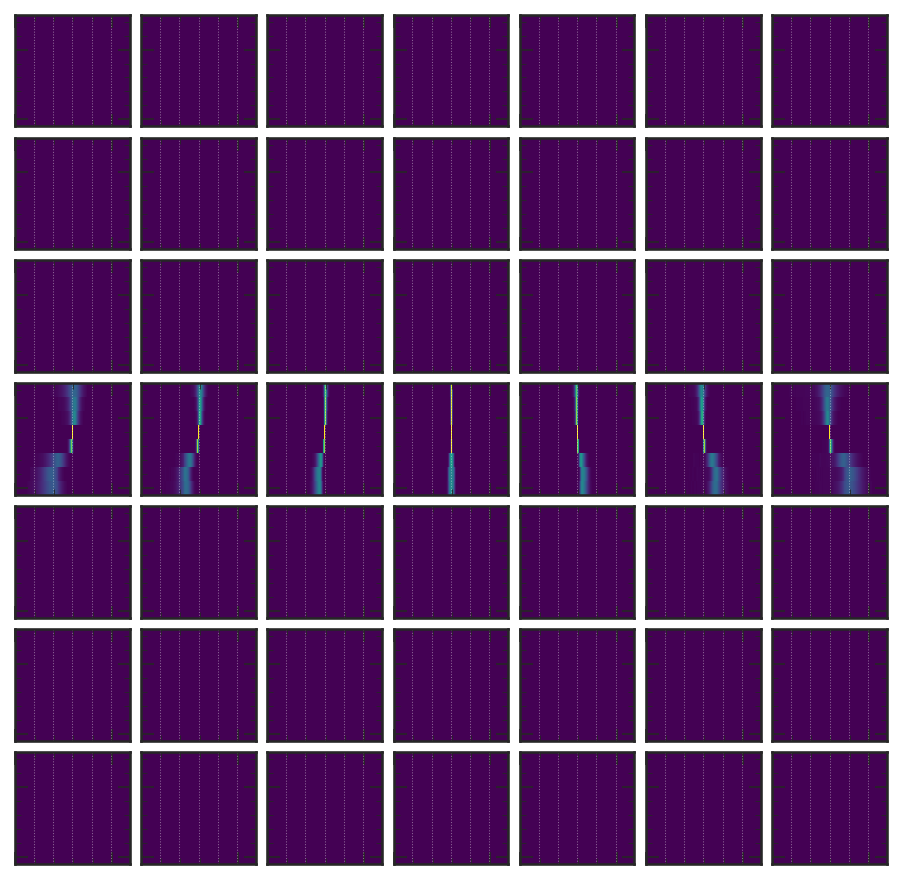

In [22]:
display_boxes(boxes_norm)